# Simple Interactive Analysis in Tornasole
This notebook will demonstrate the simplest kind of interactive analysis that can be run in smdebug. It will focus on the [vanishing/exploding gradient](https://medium.com/learn-love-ai/the-curious-case-of-the-vanishing-exploding-gradient-bf58ec6822eb) problems on a simple MNIST digit recognition.

First of all, we will import some basic libraries for deep learning and plotting.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.utils.data
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

Let's copy the Tornasole libraries to this instance, this step has to be executed only once. Please make sure that the AWS account you are using can access the tornasole-wheels-alpha bucket.

To do so you'll need the appropriate AWS credentials. There are several ways of doing this:

inject temporary credentials
if running on EC2, use EC2 roles that can access all S3 buckets
(preferred) run this notebook on a SageMaker notebook instance
The code below downloads the necessary .whl files and installs them in the current environment. Only run the first time!

In [3]:
#WARNING - uncomment this code only if you haven't done this before
#!aws s3 sync s3://tornasole-external-preview-use1/sdk/ts-binaries/tornasole_pytorch/py3/latest/ tornasole_pytorch/
#!pip install tornasole_pytorch/*

# If you run into a version conflict with boto, run the following
# !pip uninstall -y botocore boto3 aioboto3 aiobotocore && pip install botocore==1.12.91 boto3==1.9.91 aiobotocore==0.10.2 aioboto3==6.4.1

Let's import the Tornasole libraries, all we need is a `SessionHook` to use as a callback, as well as some ancillary data structures.

In [4]:
from smdebug.pytorch.hook import *
from smdebug.core.save_config import SaveConfig

import logging
logging.getLogger("tornasole").setLevel(logging.ERROR)

We can define a simple network - it doesn't really matter what it is.
Importantly - we **add the Tornasole Hook**. This hook will be run at every batch and will save selected tensors (in this case, all of them) to the desired directory (in this case, `'./ts_output/{run_id}'`.

See the documentation for more details.

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.add_module('conv1', nn.Conv2d(1, 20, 5, 1))
        self.add_module('conv2', nn.Conv2d(20, 50, 5, 1))
        self.add_module('fc1', nn.Linear(4*4*50, 500))
        self.add_module('fc2', nn.Linear(500, 10))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def create_net(tornasole_save_interval, base_loc, run_id):
    model = Net()
    # Create and add the hook. Arguments:
    # - save data in './{base_loc}/{run_id} - Note: s3 is also supported
    # - save every 100 batches
    # - save every tensor: inputs/outputs to each layer, as well as gradients
    hook = SessionHook(out_dir=base_loc + "/" + run_id, save_config=SaveConfig(save_interval=100), save_all=True)
    hook.register_hook(model)
    return model

And we create a simple training script. No Tornasole-specific code here, this is a slightly modified version of the [digit recognition](https://github.com/pytorch/examples/blob/master/mnist/main.py) example on the PyTorch github.

In [7]:
def transformer(data, label):
    data = data.reshape((-1,)).astype(np.float32)/255
    return data, label

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




def train(model, epochs, learning_rate, momentum, batch_size, device):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)

    val_data = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=False)
    
    # Collect all parameters from net and its children, then initialize them.
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    model = model.to(device)
    total_step = len(train_loader)
    for epoch in range(epochs):
        model.train()
        count = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(Variable(data, requires_grad = True))
            loss = F.nll_loss(output, target)
            loss.backward()
            count += 1

            optimizer.step()
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
    
#     torch.save(model.state_dict(),"mnist_params.pt")



Clear up from previous runs, we remove old data

In [8]:
!rm -rf ./ts_output/

At this point we are ready to train. For the purposes of this example, we will name this run as `'good'` because we know it will converge to a good solution. 

If you have a GPU on your machine, you can change the device line appropriately -- e.g for an NVIDIA GPU, it would be `device = torch.device("cuda")`.

In [9]:
model = create_net(tornasole_save_interval=100, base_loc='./ts_output', run_id='good')
train(model=model, epochs=4, learning_rate=0.1, momentum=0.9, batch_size=64, device = torch.device("cpu"))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.295261
Train Epoch: 0 [640/60000 (1%)]	Loss: 1.748892
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.695785
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.629404
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.355879
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.461338
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.465871
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.286747
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.262511
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.276488
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.234418
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.523879
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.582521
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.257838
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.162327
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.202325
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.204970
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.517194
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.138784
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.174099
Train Epoch: 0 [12800/60000 (

Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.028144
Train Epoch: 1 [46720/60000 (78%)]	Loss: 0.021224
Train Epoch: 1 [47360/60000 (79%)]	Loss: 0.071242
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.010806
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.110852
Train Epoch: 1 [49280/60000 (82%)]	Loss: 0.010513
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.364887
Train Epoch: 1 [50560/60000 (84%)]	Loss: 0.013409
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.419877
Train Epoch: 1 [51840/60000 (86%)]	Loss: 0.067204
Train Epoch: 1 [52480/60000 (87%)]	Loss: 0.067301
Train Epoch: 1 [53120/60000 (88%)]	Loss: 0.179633
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.168005
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.053020
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.127693
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.000790
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.638172
Train Epoch: 1 [56960/60000 (95%)]	Loss: 0.190752
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.001666
Train Epoch: 1 [58240/60000 (97%)]	Loss: 0.040600


Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.195543
Train Epoch: 3 [32640/60000 (54%)]	Loss: 0.150267
Train Epoch: 3 [33280/60000 (55%)]	Loss: 0.177324
Train Epoch: 3 [33920/60000 (57%)]	Loss: 0.038098
Train Epoch: 3 [34560/60000 (58%)]	Loss: 0.036462
Train Epoch: 3 [35200/60000 (59%)]	Loss: 0.076419
Train Epoch: 3 [35840/60000 (60%)]	Loss: 0.094155
Train Epoch: 3 [36480/60000 (61%)]	Loss: 0.276453
Train Epoch: 3 [37120/60000 (62%)]	Loss: 0.013989
Train Epoch: 3 [37760/60000 (63%)]	Loss: 0.033511
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.053062
Train Epoch: 3 [39040/60000 (65%)]	Loss: 0.002972
Train Epoch: 3 [39680/60000 (66%)]	Loss: 0.044364
Train Epoch: 3 [40320/60000 (67%)]	Loss: 0.201063
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.239112
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.301890
Train Epoch: 3 [42240/60000 (70%)]	Loss: 0.209023
Train Epoch: 3 [42880/60000 (71%)]	Loss: 0.340197
Train Epoch: 3 [43520/60000 (72%)]	Loss: 0.051514
Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.163148


## Data Analysis
Now that we have trained the system we can analyze the data. Notice that this notebook focuses on after-the-fact analysis. Tornasole also provides a collection of tools to do automatic analysis as the training run is progressing, which will be covered in a different notebook.

We import a basic analysis library, which defines a concept of `Trial`. A `Trial` is a single training run, which is depositing values in a local directory (`LocalTrial`) or S3 (`S3Trial`). In this case we are using a `LocalTrial` - if you wish, you can change the output from `./ts_output` to `s3://mybucket/myprefix` and use `S3Trial` instead of `LocalTrial`.

In [10]:
from smdebug.trials import LocalTrial

And we read the data

In [11]:
good_trial = LocalTrial('myrun', './ts_output/good')

We can list all the tensors we know something about. Each one of these names is the name of a tensor - the name is a combination of the layer name (which, in these cases, is auto-assigned by PyTorch) and whether it's an input/output/weight/bias/gradient.

In [12]:
good_trial.tensornames()

['Net_conv1.weight',
 'Net_conv1.bias',
 'Net_conv2.weight',
 'Net_conv2.bias',
 'Net_fc1.weight',
 'Net_fc1.bias',
 'Net_fc2.weight',
 'Net_fc2.bias',
 'conv1_input_0',
 'conv1_output0',
 'conv2_input_0',
 'conv2_output0',
 'fc1_input_0',
 'fc1_output0',
 'fc2_input_0',
 'fc2_output0',
 'Net_input_0',
 'Net_output0',
 'gradient/Net_fc2.bias',
 'gradient/Net_fc2.weight',
 'gradient/Net_fc1.bias',
 'gradient/Net_fc1.weight',
 'gradient/Net_conv2.weight',
 'gradient/Net_conv2.bias',
 'gradient/Net_conv1.weight',
 'gradient/Net_conv1.bias']

For each tensor we can ask for which steps we have data - in this case, every 100 steps

In [13]:
good_trial.tensor('gradient/Net_fc1.weight').steps()

[0,
 100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200,
 2300,
 2400,
 2500,
 2600,
 2700,
 2800,
 2900,
 3000,
 3100,
 3200,
 3300,
 3400,
 3500,
 3600,
 3700]

We can obtain each tensor at each step as a `numpy` array

In [14]:
type(good_trial.tensor('gradient/Net_fc1.weight').value(300))

numpy.ndarray

## Gradient Analysis

We can also create a simple function that prints the `np.mean` of the `np.abs` of each gradient. We expect each gradient to get smaller over time, as the system converges to a good solution. Now, remember that this is an interactive analysis - we are showing these tensors to give an idea of the data. 

Later on in this notebook we will run an automated analysis.

In [15]:
# Define a function that, for the given tensor name, walks through all 
# the batches for which we have data and computes mean(abs(tensor)).
# Returns the set of steps and the values

def get_data(trial, tname):
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = []
    for s in steps:
        val = tensor.value(s)
        val = np.mean(np.abs(val))
        vals.append(val)
    return steps, vals

In [16]:
def plot_gradients( lt ):
    for tname in lt.tensornames():
        if not 'gradient' in tname: continue
        steps, data = get_data(lt, tname)
        plt.plot( steps, data, label=tname)
    plt.legend()
    plt.show()

We can plot these gradiends. Notice how they are (mostly!) decreasing. We should investigate the spikes!

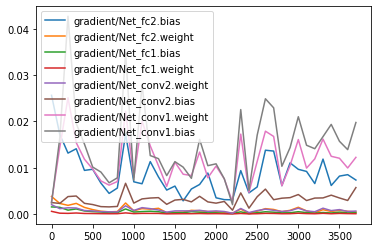

In [17]:
plot_gradients(good_trial)

We can also print inputs and outputs from the model. For instance, let's print the 42nd sample of the 2700th batch, as seen by the network. 

Notice that we have 

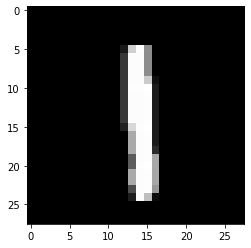

In [18]:
# The raw tensor
raw_t = good_trial.tensor('Net_input_0').value(2700)[42]
# We have to undo the transformations in 'transformer' above. First of all, multiply by 255
raw_t = raw_t * 255
# Then reshape from a 784-long vector to a 28x28 square.
input_image = raw_t.reshape(28,28)
plt.imshow(input_image, cmap=plt.get_cmap('gray'))
plt.show()

We can also plot the relative values emitted by the network. Notice that the last layer is of type `nn.Linear(500, 10)`: it will emit 10 separate confidences, one for each 0-9 digit. The one with the highest output is the predicted value.

We can capture and plot the network output for the same sample.

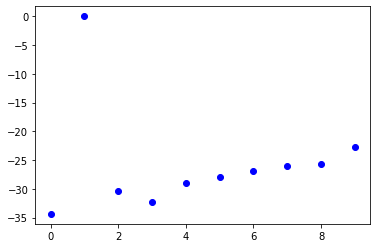

The network predicted the value: 1


In [19]:
plt.plot(good_trial.tensor('Net_output0').value(2700)[42], 'bo')
plt.show()
print('The network predicted the value: {}'.format(np.argmax(good_trial.tensor('Net_output0').value(2700)[42])))

## Vanishing Gradient

We have now worked through some of the basics. Let's pretend we are debugging a real problem: the Vanishing Gradient. When training a network, if the `learning_rate` is too high we will end up with a Vanishing Gradient. Let's set `learning_rate=1`.

Notice how the accuracy remains at around ~10% - no better than random.

In [20]:
model = create_net(tornasole_save_interval=100, base_loc='./ts_output', run_id='bad')
train(model=model, epochs=4, learning_rate=1.0, momentum=0.9, batch_size=64, device=torch.device("cpu"))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.330259
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.459480
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.342018
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.370183
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.306495
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.287591
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.284006
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.360036
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.298006
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.341758
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.304522
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.286000
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.293531
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.358820
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.307475
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.310409
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.324923
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.341324
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.346567
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.398468
Train Epoch: 0 [12800/60000 (

Train Epoch: 1 [46080/60000 (77%)]	Loss: 2.314088
Train Epoch: 1 [46720/60000 (78%)]	Loss: 2.392107
Train Epoch: 1 [47360/60000 (79%)]	Loss: 2.323653
Train Epoch: 1 [48000/60000 (80%)]	Loss: 2.294007
Train Epoch: 1 [48640/60000 (81%)]	Loss: 2.314728
Train Epoch: 1 [49280/60000 (82%)]	Loss: 2.355071
Train Epoch: 1 [49920/60000 (83%)]	Loss: 2.349204
Train Epoch: 1 [50560/60000 (84%)]	Loss: 2.307742
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.347462
Train Epoch: 1 [51840/60000 (86%)]	Loss: 2.405621
Train Epoch: 1 [52480/60000 (87%)]	Loss: 2.423558
Train Epoch: 1 [53120/60000 (88%)]	Loss: 2.382326
Train Epoch: 1 [53760/60000 (90%)]	Loss: 2.320254
Train Epoch: 1 [54400/60000 (91%)]	Loss: 2.369054
Train Epoch: 1 [55040/60000 (92%)]	Loss: 2.321925
Train Epoch: 1 [55680/60000 (93%)]	Loss: 2.321786
Train Epoch: 1 [56320/60000 (94%)]	Loss: 2.339195
Train Epoch: 1 [56960/60000 (95%)]	Loss: 2.323470
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.421056
Train Epoch: 1 [58240/60000 (97%)]	Loss: 2.329478


Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.268909
Train Epoch: 3 [32640/60000 (54%)]	Loss: 2.324456
Train Epoch: 3 [33280/60000 (55%)]	Loss: 2.313516
Train Epoch: 3 [33920/60000 (57%)]	Loss: 2.345426
Train Epoch: 3 [34560/60000 (58%)]	Loss: 2.328141
Train Epoch: 3 [35200/60000 (59%)]	Loss: 2.392569
Train Epoch: 3 [35840/60000 (60%)]	Loss: 2.333704
Train Epoch: 3 [36480/60000 (61%)]	Loss: 2.352234
Train Epoch: 3 [37120/60000 (62%)]	Loss: 2.323742
Train Epoch: 3 [37760/60000 (63%)]	Loss: 2.318627
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.340932
Train Epoch: 3 [39040/60000 (65%)]	Loss: 2.401247
Train Epoch: 3 [39680/60000 (66%)]	Loss: 2.390721
Train Epoch: 3 [40320/60000 (67%)]	Loss: 2.372447
Train Epoch: 3 [40960/60000 (68%)]	Loss: 2.381556
Train Epoch: 3 [41600/60000 (69%)]	Loss: 2.370942
Train Epoch: 3 [42240/60000 (70%)]	Loss: 2.382010
Train Epoch: 3 [42880/60000 (71%)]	Loss: 2.337266
Train Epoch: 3 [43520/60000 (72%)]	Loss: 2.327033
Train Epoch: 3 [44160/60000 (74%)]	Loss: 2.379825


In [21]:
bad_trial = LocalTrial( 'myrun', './ts_output/bad/')

We can plot the gradients - notice how every single one of them (apart from one) goes to zero and stays there!

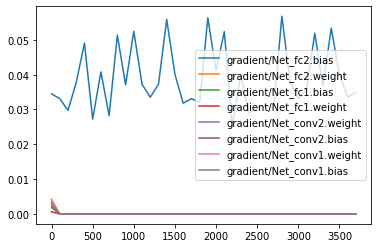

In [22]:
plot_gradients(bad_trial)

The `VanishingGradient` rule provided by Tornasole alerts for this automatically.

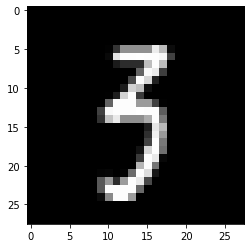

In [23]:
input_image = (bad_trial.tensor('Net_input_0').value(2700)[42]*255).reshape(28,28)
plt.imshow(input_image, cmap=plt.get_cmap('gray'))
plt.show()

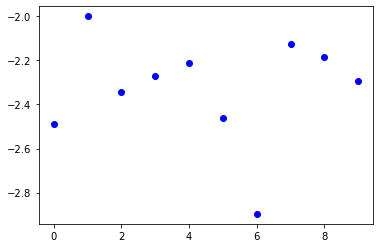

The network predicted the value: 1


In [24]:
plt.plot(bad_trial.tensor('Net_output0').value(2700)[42], 'bo')
plt.show()
print('The network predicted the value: {}'.format(np.argmax(bad_trial.tensor('Net_output0').value(2700)[42])))

This concludes this notebook. For more information see the APIs at
- https://github.com/awslabs/tornasole_core